# Stress Prediction for Nurses
## AAI 530 Group 5
### Deepti Pamula, Prema Mallikarjunan, Tommy Poole

This project uses machine learning and deep learning techniques to analyze the data found at https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors?resource=download gathered from nurses during the COVID-19 pandemic in a hospital settings, capturing real-world stress factors in a healthcare environment.

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras
import tensorflow as tf

from tqdm.keras import TqdmCallback

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, minmax_scale, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, precision_score, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Input, BatchNormalization
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# Set seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

In [3]:
# Connect data from colab
# Mount google drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Access csv data file from mounted google drive
csv_path = '/content/drive/MyDrive/AAI-530-IoT-Group5/Colab/merged_data.csv'

# Create a dataframe of the csv data
df2 = pd.read_csv(csv_path)

<ipython-input-4-d076502aae57>:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_path)


In [5]:
# Convert problematic columns to a specific data type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32")

In [ ]:
"""
# Use for local machine data import
# Import the data
df2 = pd.read_csv("merged_data.csv", low_memory=False, parse_dates=['datetime'])

# Convert problematic columns to a specific data type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32")

# Exploratory Data Analysis

In [10]:
df2.describe()

,X,Y,Z,EDA,HR,TEMP,label
count,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07
mean,-2.823775e+01,-9.091032e-01,2.382449e+01,3.502127e+00,8.576090e+01,3.223435e+01,1.554202e+00
std,3.142310e+01,3.343382e+01,2.985317e+01,5.656541e+00,1.419642e+01,2.260516e+00,7.891827e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,0.000000e+00,5.100000e+01,2.409000e+01,0.000000e+00
25%,-5.200000e+01,-1.900000e+01,4.000000e+00,2.242060e-01,7.672000e+01,3.019000e+01,1.000000e+00
50%,-3.300000e+01,1.000000e+00,2.500000e+01,1.157407e+00,8.390000e+01,3.257000e+01,2.000000e+00
75%,-1.400000e+01,1.700000e+01,4.900000e+01,4.077436e+00,9.310000e+01,3.425000e+01,2.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,5.976071e+01,1.802300e+02,3.659000e+01,2.000000e+00


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   X         float64
 1   Y         float64
 2   Z         float64
 3   EDA       float64
 4   HR        float64
 5   TEMP      float64
 6   id        object 
 7   datetime  object 
 8   label     float64
dtypes: float64(7), object(2)
memory usage: 790.3+ MB


In [11]:
# Review the end of the dataframe
df2.tail(10)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
11509041,-32.0,-43.0,56.0,3.398877,88.37,33.77,F5,2020-07-23 17:28:59.718749952,2.0
11509042,-16.0,-52.0,52.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.750000128,2.0
11509043,-47.0,-78.0,5.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.781250048,2.0
11509044,-45.0,-77.0,-24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.812499968,2.0
11509045,-51.0,-77.0,23.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.843749888,2.0
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0
11509050,-22.0,-24.0,29.0,3.374543,88.33,33.75,F5,2020-07-23 17:29:00.000000000,2.0


In [12]:
# Check for missing data
df2.isna().sum()

,0
X,0
Y,0
Z,0
EDA,0
HR,0
TEMP,0
id,0
datetime,0
label,0


In [14]:
df2.duplicated().sum()

105606

In [15]:
df2.drop_duplicates(inplace=True)

## Dataset Nine Columns Description
### (From Kaggle Project Description)

**X, Y, Z:**
Description: Numerical values representing orientation data.
Unique Entries: Each column has 256 unique values.

**EDA (Electrodermal Activity):**
Description: Continuous numerical values measuring electrodermal activity.
Unique Entries: Contains 274,452 unique numerical values.

**HR (Heart Rate):**
Description: Continuous numerical values representing heart rate measurements.
Unique Entries: Comprises 6,268 distinct numerical values.

**TEMP (Temperature):**
Description: Continuous numerical values denoting temperature readings.
Unique Entries: Contains 599 unique numerical values.

**id:**
Description: Categorical data serving as identifiers for specific subjects or entities.
Unique Entries: Consists of 18 distinct categorical entries.

**datetime:**
Description: Object type encompassing a wide range of date and time entries.
Unique Entries: Holds approximately 10.6 million unique date and time values.

**label:**
Description: Categorical data representing different states or classes.

Unique Entries: Contains three unique categorical values.
Each column in this dataset offers distinct information. The orientation data (X, Y, Z) seemingly represents spatial or directional measurements. Electrodermal activity (EDA), heart rate (HR), and temperature (TEMP) columns provide continuous physiological measurements. The 'id' column serves as a categorical identifier, while 'datetime' indicates timestamps. Lastly, the 'label' column presents categorical classifications.

In [21]:
df2.drop('datetime', axis=1).corr(numeric_only=True)

,X,Y,Z,EDA,HR,TEMP,label
X,1.000000,0.061378,0.197679,0.096056,0.128854,0.026448,-0.009016
Y,0.061378,1.000000,0.019268,-0.094499,-0.066294,-0.079620,-0.024973
Z,0.197679,0.019268,1.000000,0.006093,-0.104408,-0.031794,-0.058929
EDA,0.096056,-0.094499,0.006093,1.000000,0.141676,0.352223,0.054456
HR,0.128854,-0.066294,-0.104408,0.141676,1.000000,0.156965,-0.030715
TEMP,0.026448,-0.079620,-0.031794,0.352223,0.156965,1.000000,0.138786
label,-0.009016,-0.024973,-0.058929,0.054456,-0.030715,0.138786,1.000000


Generating Histograms: 100%|██████████| 7/7 [07:44<00:00, 66.35s/it]


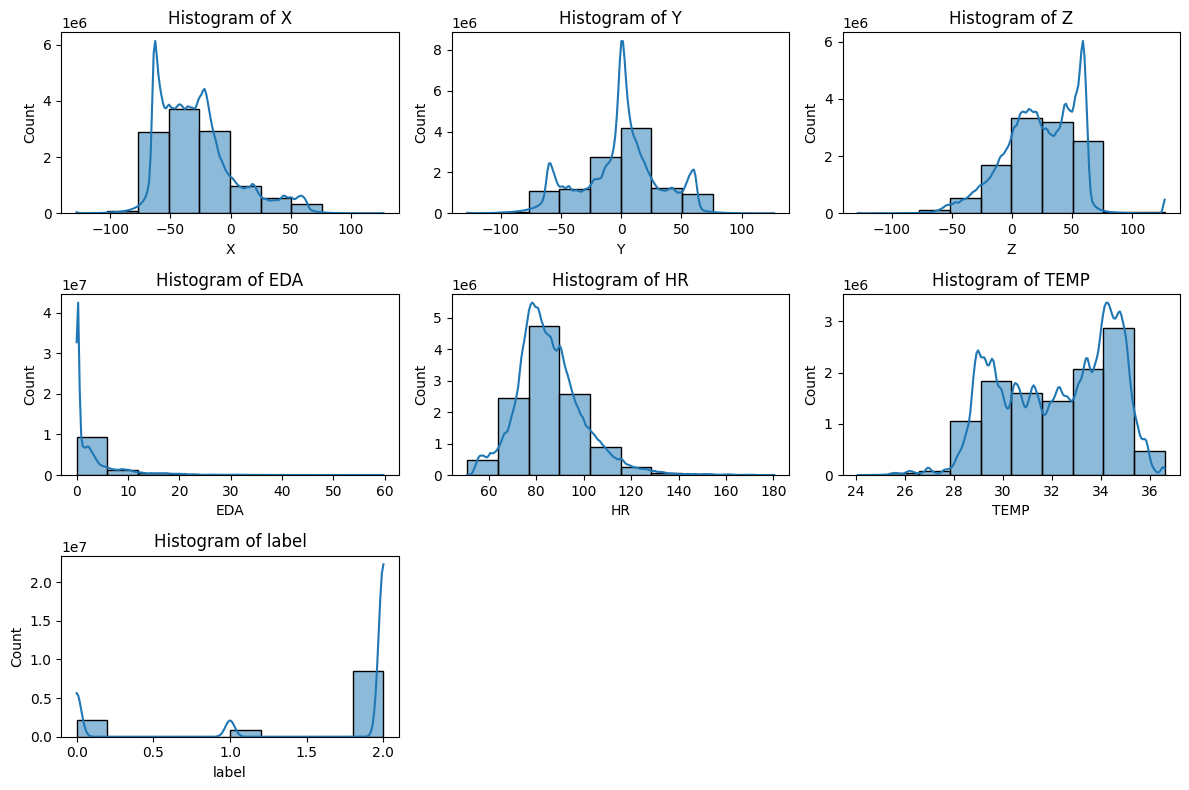

In [ ]:
# Visualize the data as histograms
plt.figure(figsize=(12, 8))
columns = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'label']

# Use tqdm to wrap the loop for progress tracking
for i, col in enumerate(tqdm(columns, desc="Generating Histograms"), 1):
    plt.subplot(3, 3, i)
    sns.histplot(df2[col], kde=True, bins=10)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [25]:
# Ensure datetime is in datetime format
df2['datetime'] = pd.to_datetime(df2['datetime'])

In [13]:
df2['time_diff'] = df2['datetime'].diff()
print(df2['time_diff'].value_counts())

time_diff
0 days 00:00:00.031249920    7912322
0 days 00:00:00.031250176    3596510
0 days 00:12:00                    3
0 days 00:09:00                    3
0 days 00:10:00                    3
                              ...   
3 days 04:13:00                    1
0 days 00:51:00                    1
-1 days +12:26:00                  1
0 days 02:20:00                    1
0 days 02:14:00                    1
Name: count, Length: 196, dtype: int64


In [14]:
# Set datetime as the index
df2.set_index('datetime', inplace=True)

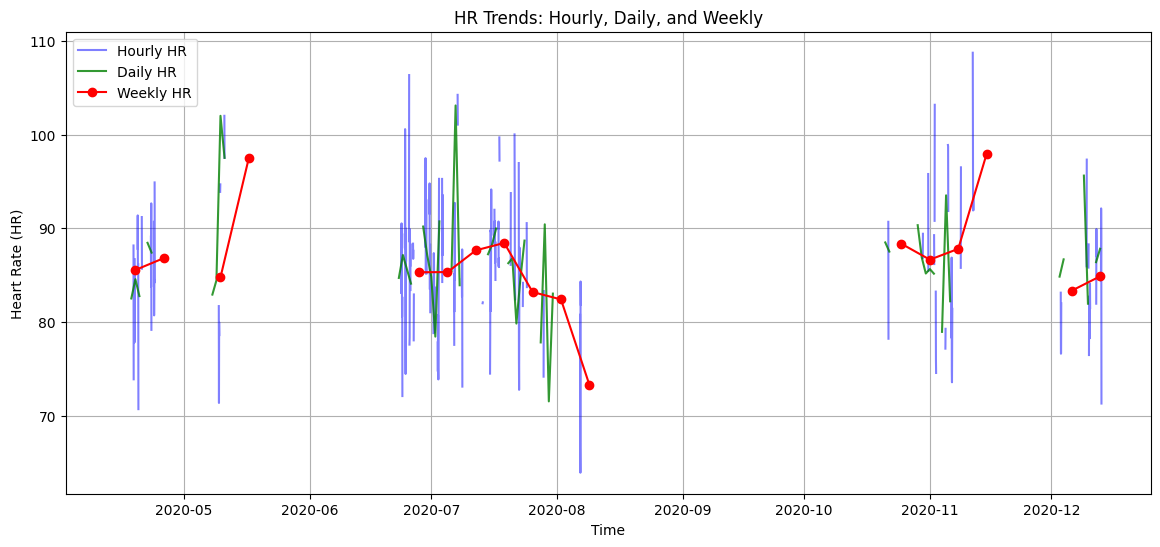

In [15]:
# Add hourly, daily, weekly attributes to capture trends for heartrate
hr_hourly = df2['HR'].resample('h').mean()
hr_daily = df2['HR'].resample('D').mean()
hr_weekly = df2['HR'].resample('W').mean()
data_hourly = df2[['X', 'Y', 'Z', 'EDA', 'HR']].resample('h').mean()

# Visualize the data to look for trends
plt.figure(figsize=(14, 6))

# Plot all hourly, daily and weekly trends
plt.plot(hr_hourly, linestyle='-', alpha=0.5, color='blue', label='Hourly HR')
plt.plot(hr_daily, linestyle='-', alpha=0.8, color='green', label='Daily HR')
plt.plot(hr_weekly, linestyle='-', alpha=1.0, color='red', marker='o', label='Weekly HR')
plt.xlabel("Time")
plt.ylabel("Heart Rate (HR)")
plt.title("HR Trends: Hourly, Daily, and Weekly")
plt.legend()
plt.grid(True)

plt.show()

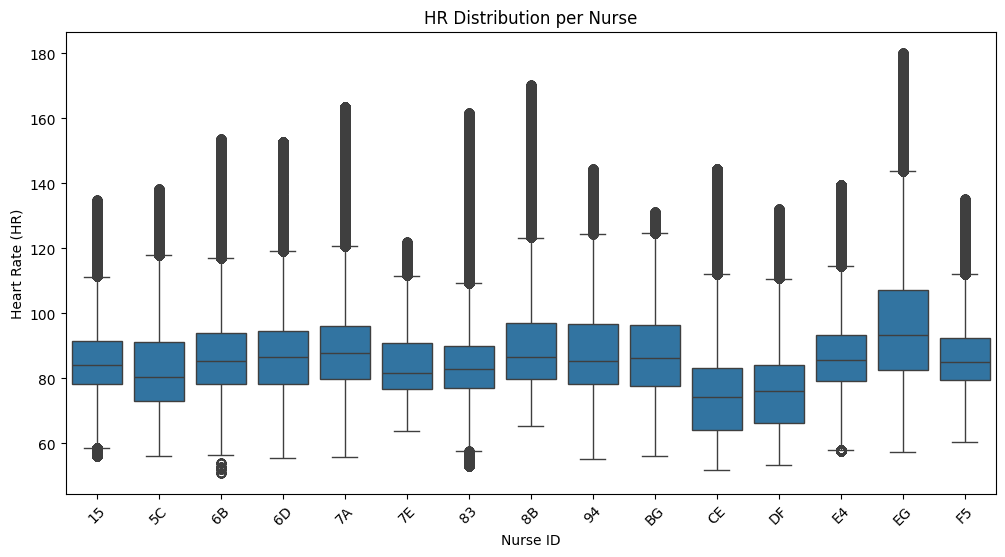

In [16]:
# Check heartrate for trends in boxplot format
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='HR', data=df2)
plt.title('HR Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Heart Rate (HR)')
plt.xticks(rotation=45)
plt.show()

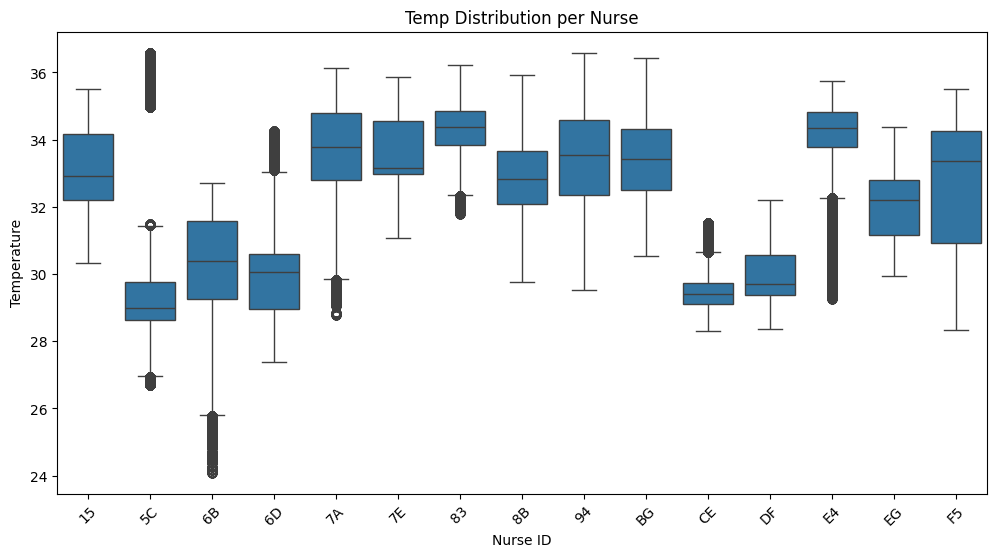

In [ ]:
# Check the temperature field in boxplot format to check for trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='TEMP', data=df2)
plt.title('Temp Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

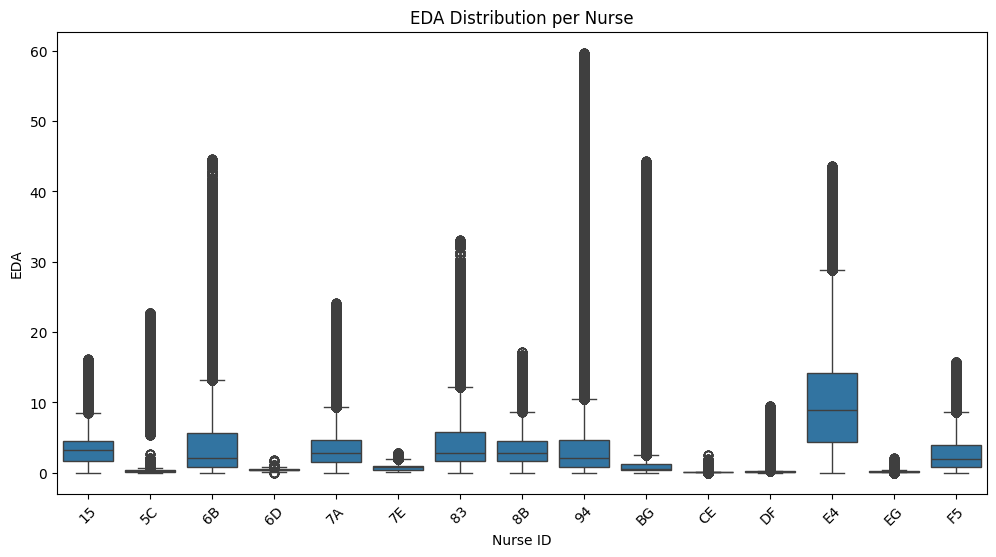

In [ ]:
# Plot the EDA in boxplot to explore trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='EDA', data=df2)
plt.title('EDA Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('EDA')
plt.xticks(rotation=45)
plt.show()

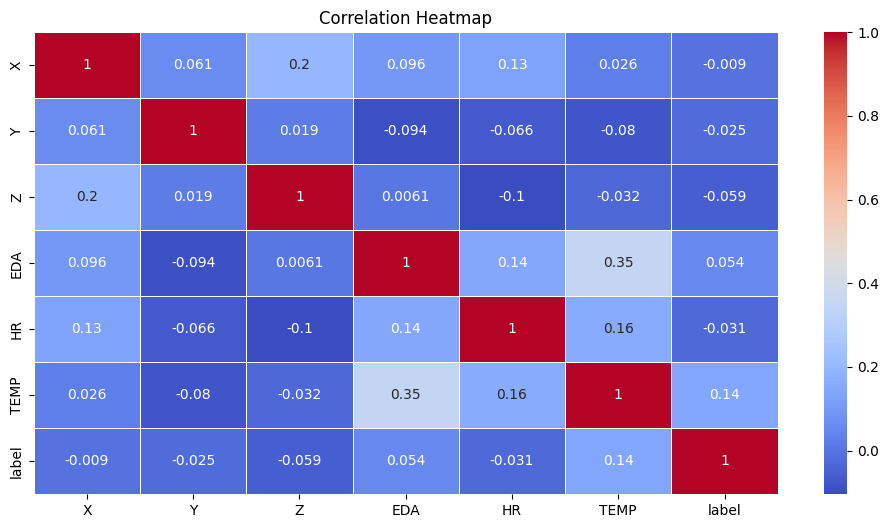

In [22]:
plt.figure(figsize=(12,6))
sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Label Encoding for 'id'
le = LabelEncoder()
df2['id_encoded'] = le.fit_transform(df2['id'])

# One-Hot Encoding for 'label'
ohe = OneHotEncoder(sparse_output=False)
label_encoded = ohe.fit_transform(df2[['label']])
label_columns = ohe.get_feature_names_out(['label'])
df2[label_columns] = label_encoded

In [7]:
# Ensure datetime is in datetime format
df2['datetime'] = pd.to_datetime(df2['datetime'])

In [8]:
# Index the dataset by datetime
df2.set_index('datetime', inplace=True)

# Models

## Random Forest Machine Learning Algorithm

Data preprocessing for stress prediction.

In [18]:
# Reset the index so that
df2 = df2.reset_index()

In [19]:
# Convert datetime into more meaningful units for Random Forest Classifier
df2['time_of_day'] = df2['datetime'].dt.hour
df2['day_of_week'] = df2['datetime'].dt.dayofweek
df2['month'] = df2['datetime'].dt.month
df2['day_of_month'] = df2['datetime'].dt.day

In [20]:
# Confirm column creation for debugging
print(df2.columns)

Index(['datetime', 'X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'label',
       'time_diff', 'time_of_day', 'day_of_week', 'month', 'day_of_month'],
      dtype='object')


In [22]:
features = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id_encoded', 'time_of_day','day_of_month', 'day_of_week', 'month']
X = df2[features]
y = df2['label'] # Using the columns of data above to predict stress in the label column

In [23]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Define the number of trees (reduced to 10 for faster execution)
n_estimators = 10

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    432097
           1       1.00      1.00      1.00    160853
           2       1.00      1.00      1.00   1708861

    accuracy                           1.00   2301811
   macro avg       1.00      1.00      1.00   2301811
weighted avg       1.00      1.00      1.00   2301811


Confusion Matrix:
[[ 432079       0      18]
 [      2  160851       0]
 [     22       0 1708839]]


In [ ]:
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_classifier.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
         feature  importance
8   day_of_month    0.187155
7    time_of_day    0.175599
6     id_encoded    0.171120
3            EDA    0.140256
9    day_of_week    0.110712
5           TEMP    0.099898
10         month    0.066491
4             HR    0.017580
2              Z    0.011660
0              X    0.010875
1              Y    0.008654


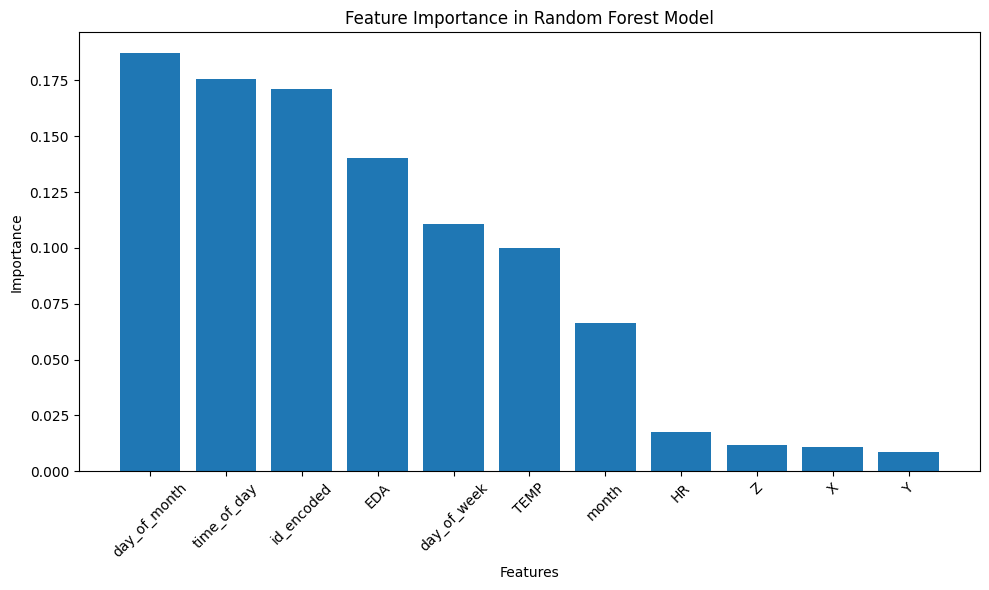

In [ ]:
# Visualie feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model 2 - Deep Learning Long Short Term Memory (LSTM) Model


1. Can we predict EDA  using the other variables?

In [9]:
# Create a copy of the data called d3
df3 = df2.copy()

In [10]:
# Sort the dataframe by timestamp
df3 = df3.sort_values('datetime')

percent_marks = [int(len(df3) * i / 10) for i in range(1, 10)]

# Create a subset of data selecting 3 sections of consecutive rows
df_subset = pd.DataFrame()
num_sections = 5
section_size = int(len(df3) * 0.01)  # 1% of the data

for i in range(num_sections):
    print(f"Processing section {i + 1}/{num_sections}")
    start_index = percent_marks[i]
    end_index = start_index + section_size
    consecutive_section = df3.iloc[start_index:end_index]
    df_subset = pd.concat([df_subset, consecutive_section])

# Remove the selected rows from df3
df3 = df3.drop(df_subset.index)

Processing section 1/5
Processing section 2/5
Processing section 3/5
Processing section 4/5
Processing section 5/5


In [11]:
# Print total number of rows in df_subset
print(f"Total number of rows in df_subset: {len(df_subset)}")

Total number of rows in df_subset: 575450


In [12]:
# Define nurse id as id
nurse_ids = df_subset['id_encoded'].unique()

# Print row count for each nurse in subset dataframe
for nurse_id in nurse_ids:
    nurse_data = df_subset[df_subset['id_encoded'] == nurse_id]
    print(f"Nurse ID {nurse_id}: {len(nurse_data)} rows")

Nurse ID 10: 78947 rows
Nurse ID 8: 118990 rows
Nurse ID 1: 82448 rows
Nurse ID 12: 265072 rows
Nurse ID 4: 29993 rows


In [13]:
# Truncate each nurse to use only the last 10000 rows
df_subset = df_subset.groupby('id_encoded').tail(10000)

In [14]:
# Normalize the data using minmax scaler
scaler = MinMaxScaler()
df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']] = scaler.fit_transform(df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']])

<ipython-input-14-2a9b6f60ed7f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']] = scaler.fit_transform(df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']])


In [15]:
# Get unique nurse IDs
unique_nurse_ids = df_subset['id_encoded'].unique()

# Determine the number of nurses
num_nurses = len(unique_nurse_ids)

# Keep the last nurses for validation
val_nurse_ids = unique_nurse_ids[-3:]

# Create training and validation sets based on nurse IDs
train_df = df_subset[~df_subset['id_encoded'].isin(val_nurse_ids)]
val_df = df_subset[df_subset['id_encoded'].isin(val_nurse_ids)]

In [16]:
# Print the length of the train and val df
print(f"Length of train_df: {len(train_df)}")
print(f"Length of val_df: {len(val_df)}")

Length of train_df: 20000
Length of val_df: 30000


In [17]:
# Define features and label_column
features = ['TEMP', 'EDA']
label_column = 'HR'

def create_sequences(group, sequence_length, ph):
    sequences = []
    labels = []
    for i in range(len(group) - sequence_length - ph + 1):
        seq = group[features].iloc[i:i+sequence_length].values
        label = group[label_column].iloc[i + sequence_length + ph - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 30  # 30 time steps
ph = 5  # 5 time steps

X_sequences = []
y_sequences = []


for nurse_id in tqdm(train_df['id_encoded'].unique(), desc="Processing nurses"):
    nurse_data = train_df[train_df['id_encoded'] == nurse_id]
    X_seq, y_seq = create_sequences(nurse_data, sequence_length, ph)
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)

# Combine all sequences
X_sequences = np.concatenate(X_sequences)
y_sequences = np.concatenate(y_sequences)

print(f"Total sequences: {len(X_sequences)}")
print(f"Shape of X_sequences: {X_sequences.shape}")
print(f"Shape of y_sequences: {y_sequences.shape}")

Processing nurses: 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]

Total sequences: 19932
Shape of X_sequences: (19932, 30, 2)
Shape of y_sequences: (19932,)


In [18]:
# Adjust the X and y sequences into numpy arrays to ensure they're in the correct format for tensor flow
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [19]:
# Define input shape
input_shape = (sequence_length, len(features))

# Fit the model
model = Sequential([
    Input(shape=input_shape),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(16, return_sequences=False, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Define the optimizer
optimizer = Adam(learning_rate=0.01)

# Compile the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [20]:
# Calculate the number of samples for validation
val_size = int(len(X_sequences) * 0.2)

# Split the data, keeping the last 20% for validation
X_train = X_sequences[:-val_size]
y_train = y_sequences[:-val_size]
X_val = X_sequences[-val_size:]
y_val = y_sequences[-val_size:]

# Define the number of epochs and batch size
epochs = 5
batch_size = 500

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ],
    verbose=1
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 1.8210 - mae: 0.5472 - val_loss: 0.7391 - val_mae: 0.1777 - learning_rate: 0.0100
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.6886 - mae: 0.2375 - val_loss: 0.3879 - val_mae: 0.1068 - learning_rate: 0.0100
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.3859 - mae: 0.1703 - val_loss: 0.2633 - val_mae: 0.0735 - learning_rate: 0.0100
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - loss: 0.2659 - mae: 0.1272 - val_loss: 0.2019 - val_mae: 0.0741 - learning_rate: 0.0100
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - loss: 0.2012 - mae: 0.1021 - val_loss: 0.1597 - val_mae: 0.0557 - learning_rate: 0.0100


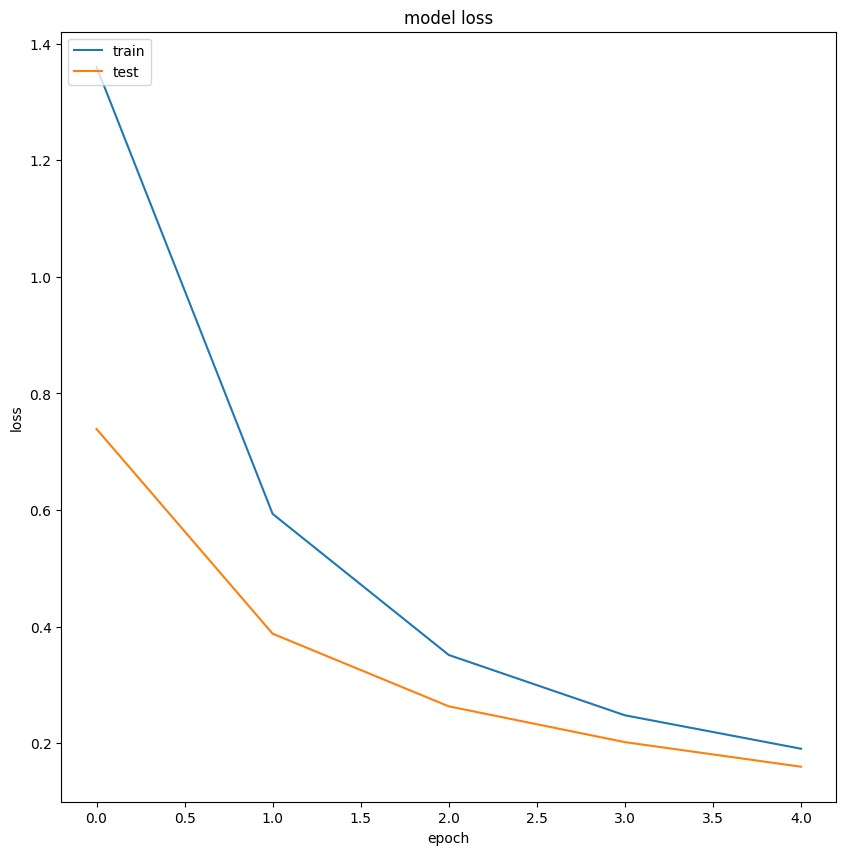

In [21]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [22]:
# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1591 - mae: 0.0461
Validation Loss: [0.15969502925872803, 0.055700063705444336]


In [26]:
val_arrays = []
val_labs = []

# First create your sequences
for i in range(len(val_df) - sequence_length - ph):
    if i + sequence_length + ph < len(val_df):
        val_arrays.append(val_df[features].iloc[i:i+sequence_length].values)
        val_labs.append(val_df['HR'].iloc[i+sequence_length+ph-1])

# Use the pad_sequences function on your input sequences
padded_sequences = pad_sequences(val_arrays,
                               maxlen=sequence_length,
                               padding='post',  # pad at start of sequence
                               truncating='post',  # truncate at end if needed
                               value=0.0)  # use 0.0 for padding value

# Remember that we will later want our datatype to be np.float32
val_arrays = np.array(padded_sequences, dtype = object).astype(np.float32)

# Convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


937/937 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


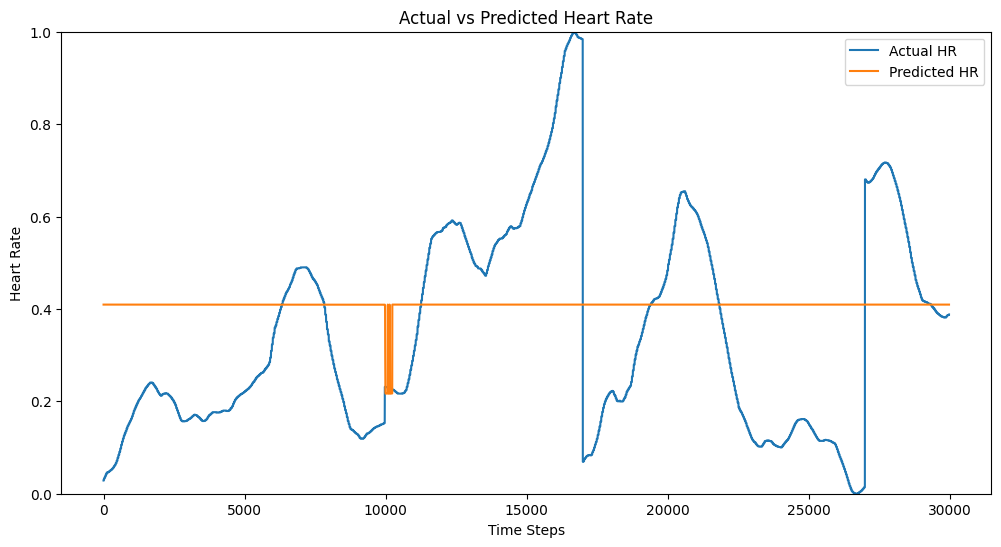

In [27]:
# Make predictions on the validation data
predictions = model.predict(val_arrays)

# Reshape predictions if necessary
if predictions.ndim == 3:
    predictions = predictions[:, -1, 0]  # Select the last time step and first (only) feature

# Plot
plt.figure(figsize=(12, 6))
plt.plot(val_labs, label='Actual HR')
plt.plot(predictions, label='Predicted HR')
plt.title('Actual vs Predicted Heart Rate')
plt.xlabel('Time Steps')
plt.ylabel('Heart Rate')

# Set y-axis limits to show full range
plt.ylim([min(min(val_labs), min(predictions)), max(max(val_labs), max(predictions))])

plt.legend()
plt.show()